# Analyzing Text

Write the TextAnalyzer class in the cell below. We have already imported some libraries that should be useful to you.

In [42]:
import requests, re
from bs4 import BeautifulSoup
from collections import Counter
import statistics as stats
import string

class TextAnalyzer:
    "Analyzes a text"
    def __init__(self, src, src_type='discover'):
        """Creates a object for analyzing text

        Keyword arguments:
        src (str) -- text, path to file, or url
        src_type (str)
            -- 'discover' : determine if src is a url, path to file, or text (default)
            -- 'url' : website url beginning with "http"
            -- 'path' : the path to a txt file ending with file extension "txt"
            -- 'text' : text supplied by the user
        """
        self._src_type = src_type
        self._content = None
        self._orig_content = src

        if self._src_type == 'discover':
            if self._orig_content[:4] == 'http':
                self._src_type = 'url'
            elif self._orig_content[-3:] == 'txt':
                self._src_type = 'path'
            else:
                self._src_type = 'text'
                self._content = src
        elif self._src_type == 'path':
            with open(self._orig_content, encoding='utf-8') as txt_file:
                self._content = txt_file.read()
        else:
            self._content = src
        
    def set_content_to_tag(self, tag, tag_id=None):
        """Changes _content to the text within a specific element
        of an HTML document

        Keyword arguments:
        tag (str) -- Tag to read
        tag_id (str) -- ID of tag to read
        """
        r = requests.get(self._orig_content)
        content = r.text
        soup = BeautifulSoup(content, 'lxml')
        try:
            self._content = soup.find(tag, id=tag_id).text
        except:
            raise Exception('tag was not found')

    def reset_content(self):
        """Resets _content to full text that was originally loaded."""
        r = requests.get(self._orig_content)
        content = r.text
        self._content = content    

    def _words(self, casesensitive=False):
        """Returns words in content as list.

        Keyword arguments:
        casesensitive (bool) -- If False makes all words uppercase.       
        """
        words = self._content.split()
        words_strip = [word.strip(string.punctuation) for word in words]
        if casesensitive == False:
            return [word.upper() for word in words_strip]
        else:
            return words_strip

    def common_words(self, minlen=1, maxlen=100, count=10, casesensitive=False):
        """Returns a list of 2-element tuples of the format (word, num),
        where num is the number of times word shows up in content

        Keyword arguments:
        minlen (int) -- Minimum length of words to include.
        maxlen (int) -- Maximum length of words to include.
        count (int) -- Number of words to include.
        casesensitive (bool) -- If False makes all words uppercase.
        """
        words = re.split("'| |-|\n", self._content)
        words_strip = [word.strip(string.punctuation) for word in words]
        if casesensitive == False:
            words_strip = [word.upper() for word in words_strip]
        final_list = [word for word in words_strip if len(word) >= minlen and len(word) <= maxlen]
        return Counter(final_list).most_common(count)

    def char_distribution(self, casesensitive=False, letters_only=False):
        """Returns a list of 2-element tuples of the format (char, num),
        where num is the number of times char shows up in content

        Keyword arguments:
        casesensitive (bool) -- If False makes all words uppercase.
        letters_only (bool) -- If False includes non-letters.
        """
        words = ''.join(self._words(casesensitive))
        if letters_only == True:
            p = re.compile(r'[A-Za-z]')
            words = p.findall(words)
        return Counter(words).most_common()

    def plot_common_words(self, minlen=1, maxlen=100, count=10, casesensitive=False):
        """Plots most common words.

        Keyword arguments:
        minlen (int) -- Minimum length of words to include.
        maxlen (int) -- Maximum length of words to include.
        count (int) -- Number of words to include.
        casesensitive (bool) -- If False makes all words uppercase.
        """
        index_names = []
        values = []
        common_words = self.common_words(minlen, maxlen, count, casesensitive)
        for tuple in common_words:
            index_names.append(tuple[0])
            values.append(tuple[1])
        ps = pd.Series(values, index=index_names)
        plt_ps = ps.plot(
            kind = 'bar',
            title = "Common Words",
            figsize = (12, 4),
            width = 0.75
        )
        plt_ps.set_yticks(np.arange(0, 800, 100))
        plt_ps.tick_params(left = False, bottom = False)
        plt_ps.set_axisbelow(True)
        plt_ps.grid(True, linestyle = 'dotted');

    def plot_char_distribution(self, casesensitive=False, letters_only=False):
        """Plots character distribution.

        Keyword arguments:
        casesensitive (bool) -- If False makes all words uppercase.
        letters_only (bool) -- If False includes non-letters.        
        """
        index_names = []
        values = []
        char_list = self.char_distribution(casesensitive, letters_only)
        for tuple in char_list:
            index_names.append(tuple[0])
            values.append(tuple[1])
        ps = pd.Series(values, index=index_names)
        plt_ps = ps.plot(
            kind = 'bar',
            title = 'Character Distribution',
            figsize = (12, 4),
            width = 0.75
        )
        plt_ps.set_ylim(0, 70000)
        plt_ps.tick_params(left = False, bottom = False)
        plt_ps.set_axisbelow(True)
        plt_ps.grid(True, linestyle = 'dotted');

    @property
    def content(self):
        """Returns content"""
        return self._content

    @property
    def words(self):
        """A list of all words used in content,
        including repeats, in all uppercase letters."""
        return self._words()

    @property
    def avg_word_length(self):
        """Average word length"""
        words = self._words()
        length_array = [len(word) for word in words]
        return round(sum(length_array) / len(length_array), 2)

    @property
    def word_count(self):
        """Number of words in content"""
        return len(self._words())

    @property
    def distinct_word_count(self):
        """Number of distinct words in content"""
        return len(set(self._words()))

    @property
    def positivity(self):
        """A positivity score calculated as follows:
        * Create local tally variable with initial value of 0.
        * Increment tally by 1 for every word in self.words found in positive.txt
        * Decrement tally by 1 for every word in self.words found in negative.txt
        * Calculate score as follows:
            round( tally / self.word_count * 1000)
        """
        tally = 0
        with open('positive.txt', encoding='utf-8') as f:
            pos_list = f.read().splitlines()
        with open('negative.txt', encoding='utf-8') as f:
            neg_list = f.read().splitlines()
        for word in self.words:
            if word in pos_list:
                tally += 1
            elif word in neg_list:
                tally -= 1
        return round(tally/self.word_count * 1000)

## Tests
When you have finished, you should run the tests below. If you get errors, you should do your very best to fix those errors before submitting the project.

If you submit your project while still getting errors, you should explain that in your project submission email. The very first thing we will do to grade your project is run it through these tests. If it fails any of the tests, and you have not indicated that you are aware of specific test failures, we will stop grading and ask you to resubmit.

In [43]:
import unittest

url = 'https://static.webucator.com/media/public/documents/clinton.html'
path = 'pride-and-prejudice.txt'
text = '''The outlook wasn't brilliant for the Mudville Nine that day;
the score stood four to two, with but one inning more to play.
And then when Cooney died at first, and Barrows did the same,
a sickly silence fell upon the patrons of the game.'''

class TestTextAnalyzer(unittest.TestCase):
    def test_discover_url(self):
        ta = TextAnalyzer(url)
        self.assertEqual(ta._src_type, 'url')
    def test_discover_path(self):
        ta = TextAnalyzer(path)
        self.assertEqual(ta._src_type, 'path')
    def test_discover_text(self):
        ta = TextAnalyzer(text)
        self.assertEqual(ta._src_type, 'text')
    def test_set_content_to_tag(self):
        ta = TextAnalyzer(url)
        ta.set_content_to_tag('div','content-main')
        self.assertEqual(ta._content[0:23], 'Address by Bill Clinton')
    def test_reset_content(self):
        ta = TextAnalyzer(url)
        ta.set_content_to_tag('div','content-main')
        ta.reset_content()
        self.assertEqual(ta._content[0], '<')
    def test_common_words(self):
        ta = TextAnalyzer(path, src_type='path')
        common_words = ta.common_words(minlen=5, maxlen=10)
        liz = common_words[0]
        self.assertEqual(liz[0],'ELIZABETH')
    def test_avg_word_length(self):
        ta = TextAnalyzer(text, src_type='text')
        self.assertEqual(ta.avg_word_length, 4.16)
    def test_word_count(self):
        ta = TextAnalyzer(text, src_type='text')
        self.assertEqual(ta.word_count, 45)
    def test_distinct_word_count(self):
        ta = TextAnalyzer(text, src_type='text')
        self.assertEqual(ta.distinct_word_count, 38)
    def test_char_distribution(self):
        ta = TextAnalyzer(text, src_type='text')
        char_dist = ta.char_distribution(letters_only=True)
        self.assertEqual(char_dist[1][1], 20)
    def test_positivity(self):
        ta = TextAnalyzer(text, src_type='text')
        positivity = ta.positivity
        self.assertEqual(positivity, -44)
        
suite = unittest.TestLoader().loadTestsFromTestCase(TestTextAnalyzer)
unittest.TextTestRunner().run(suite)

...........
----------------------------------------------------------------------
Ran 11 tests in 0.336s

OK


<unittest.runner.TextTestResult run=11 errors=0 failures=0>

## Plots
You should also run the cell below to make sure your plot methods work. They should produce plots that look like the images found at:
* <a href="character-distribution.png" target="image_win">character-distribution.png</a>
* <a href="common-words.png" target="image_win">common-words.png</a>

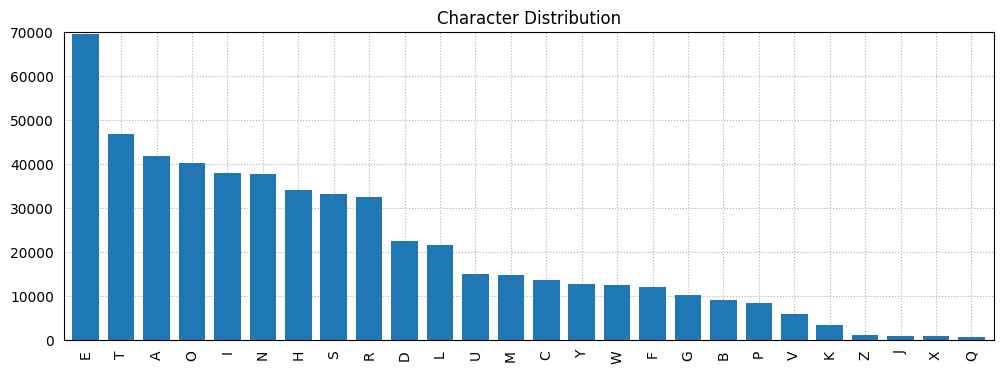

In [47]:
%matplotlib inline
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

ta = TextAnalyzer('pride-and-prejudice.txt', src_type='path')
ta.plot_common_words(minlen=5)
ta.plot_char_distribution(letters_only=True)

## Exam: Using the TextAnalyzer

### Question 1
How many words are in the text of William Henry Harrison's 1841 inaugural address?
* The address can be found at https://static.webucator.com/media/public/documents/harrison.html.
* Its contents are in a div tag with the id 'content-main'.

In [48]:
ta = TextAnalyzer('https://static.webucator.com/media/public/documents/harrison.html', src_type='url')
ta.set_content_to_tag('div','content-main')
ta.word_count

8430

### Question 2
What is the least common letter in pride-and-prejudice.txt?

In [49]:
ta = TextAnalyzer('pride-and-prejudice.txt', src_type='path')
ta.char_distribution(casesensitive=False, letters_only=True)

[('E', 69372),
 ('T', 46645),
 ('A', 41682),
 ('O', 40043),
 ('I', 37830),
 ('N', 37688),
 ('H', 34069),
 ('S', 33110),
 ('R', 32300),
 ('D', 22299),
 ('L', 21592),
 ('U', 14986),
 ('M', 14765),
 ('C', 13461),
 ('Y', 12705),
 ('W', 12308),
 ('F', 12001),
 ('G', 10033),
 ('B', 9089),
 ('P', 8226),
 ('V', 5726),
 ('K', 3209),
 ('Z', 936),
 ('J', 871),
 ('X', 839),
 ('Q', 627)]

### Question 3
What is the most common 11-letter word in pride-and-prejudice.txt?  

In [50]:
ta.common_words(minlen=11, maxlen=11, count=1, casesensitive=False)

[('NETHERFIELD', 73)]

### Question 4
What is the average word length in pride-and-prejudice.txt?

In [51]:
ta.avg_word_length

4.43

### Question 5
How many distinct words are there in pride-and-prejudice.txt?

In [52]:
ta.distinct_word_count

6839

### Question 6
How many words, ignoring case, are used only once in pride-and-prejudice.txt?

In [53]:
full_list = ta.words
count_list = Counter(full_list).most_common()
precious_words = [word for word in count_list if word[1] == 1]
len(precious_words)

2886

### Question 7
How many distinct words in pride-and-prejudice.txt have less than five characters, at least one character of which is a capital 'A'.

In [54]:
distinct_words = set(ta._words(casesensitive=True))
short_words = [word for word in distinct_words if len(word) < 5]
a_words = []
for word in short_words:
    if word.find('A') != -1:
      a_words.append(word)
len(a_words)

13

### Question 8
A palindrome is a word spelled the same forwards and backwards, like BOB. How many distinct palindromes are there in pride-and-prejudice.txt.
* Only include words with at least three letters.

In [55]:
distinct_words = set(ta.words)
longer_words = [word for word in distinct_words if len(word) >= 3]
pals = []
for word in longer_words:
    if word == word[::-1]:
        pals.append(word)
len(pals)

9

### Question 9
What is the positivity rating of 'pride-and-prejudice.txt'

In [56]:
ta.positivity

11

### Question 10
Which of the following addresses (originally from http://www.inaugural.senate.gov/swearing-in/addresses) has the lowest positivity rating?
1. https://static.webucator.com/media/public/documents/bush.html
1. https://static.webucator.com/media/public/documents/truman.html
1. https://static.webucator.com/media/public/documents/mckinley.html
1. https://static.webucator.com/media/public/documents/taylor.html

Note the contents of the addresses are in a div tag with the id 'content-main'.

In [57]:
url_1 = 'https://static.webucator.com/media/public/documents/bush.html'
url_2 = 'https://static.webucator.com/media/public/documents/truman.html'
url_3 = 'https://static.webucator.com/media/public/documents/mckinley.html'
url_4 = 'https://static.webucator.com/media/public/documents/taylor.html'
urls = [url_1, url_2, url_3, url_4]
pres = ['Bush', 'Truman', 'McKinley', 'Taylor']
pos_score = []
for url in urls:
    ta = TextAnalyzer(url)
    ta.set_content_to_tag('div','content-main')
    pos_score.append(ta.positivity)
pres_pos = dict(zip(pres, pos_score))
pres_pos

{'Bush': 39, 'Truman': 49, 'McKinley': 31, 'Taylor': 50}

In [58]:
help(TextAnalyzer)

Help on class TextAnalyzer in module __main__:

class TextAnalyzer(builtins.object)
 |  TextAnalyzer(src, src_type='discover')
 |  
 |  Analyzes a text
 |  
 |  Methods defined here:
 |  
 |  __init__(self, src, src_type='discover')
 |      Creates a object for analyzing text
 |      
 |      Keyword arguments:
 |      src (str) -- text, path to file, or url
 |      src_type (str)
 |          -- 'discover' : determine if src is a url, path to file, or text (default)
 |          -- 'url' : website url beginning with "http"
 |          -- 'path' : the path to a txt file ending with file extension "txt"
 |          -- 'text' : text supplied by the user
 |  
 |  char_distribution(self, casesensitive=False, letters_only=False)
 |      Returns a list of 2-element tuples of the format (char, num),
 |      where num is the number of times char shows up in content
 |      
 |      Keyword arguments:
 |      casesensitive (bool) -- If False makes all words uppercase.
 |      letters_only (bool) 